<a href="https://colab.research.google.com/github/tkota0726/Generative-Adversarial-Networks-for-financial-time-series-generation/blob/master/ML_Prediction/Notebook/WindTemp_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center">RBA Prediction Part with Attention</h1>

# Table of contents

1. [Library Import](#Library) 
* [Data Extract Class](#Data)  
  2.1 [Data Source Information](#DataSource)  
* [Batch Generator Function](#Batch)  
* [Checkpoint, Loss and Callback functions](#Check)  
* [Plot Class](#Plot)  
* [Structure of Data](#Structrue)  
* [LSTM with Multi inputs](#LSTM)  
* [GRU with Multi inputs](#GRU)  
* [ANN with Multi Inputs](#ANN)  
* [Attention with Multi Inputs](#Attention)  
* [Gans with Multi Inputs](#Gans)  


## Library Import
<a name="library"> </a>

In [0]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series
from datetime import datetime
# import tensorflow as tf
import numpy as np
import time
from keras.callbacks import ModelCheckpoint


import io
import os
import os.path
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Flatten, Dropout, Lambda, Activation, Input
from keras import losses
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.layers.core import Layer
from keras.layers.core import K
from keras import initializers, regularizers, constraints  
from keras import metrics
from tensorboardcolab import *

!pip install pydrive
## Tensorflow board

# !pip install -q tf-nightly-2.0-preview
!pip install tensorboard

# Load the TensorBoard notebook extension
# %load_ext tensorboard.notebook
# %reload_ext tensorboard.notebook
%matplotlib inline


Using TensorFlow backend.


    100% |████████████████████████████████| 993kB 20.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


<a name="Data"> </a>
## Data Extract Class


### Data Source Information
"# Renewables.ninja Wind (hourly data, split by on/offshore, 1980-2016) - ninja_wind_country_EE_current-merra-2_corrected - Version: 1.1 - License: https://creativecommons.org/licenses/by-nc/4.0/ - Reference: https://doi.org/10.1016/j.energy.2016.08.068",
"# Units: time in UTC, other columns are capacity factors [0-1]. Simulation represents 297 MW of capacity, all of which onshore. Bias corrected using national generation data.",
time,national

In [0]:
class GenerateData:
    def __init__(self):
        pass

    # Data Extract Section
    def dataDriveExtract():
        auth.authenticate_user()  # Auth check
        gauth = GoogleAuth()  # google Auth Instance
        gauth.credentials = GoogleCredentials.get_application_default()  # credential part
        drive = GoogleDrive(gauth)  # put the credential information to drive

        # Specify the file location about Estonia
        downloaded = drive.CreateFile({'id': fileId})
        # download the file with the file name
        downloaded.GetContentFile(fileName)
        # load the data via pandas
        data = pd.read_excel(fileName, encoding='utf-8')
        data = data.set_index('time')  # set 'time' as the index
        return data

    def dataLocalExtract():
        data = pd.read_excel(fileName, encoding='utf-8')
        data = data.set_index('time')
        # series = Series.from_csv('wind1980_2016EE.csv', encoding = 'utf-8', header=0)
        return data

### Structure of  Data and Change the format

In [0]:
## TImeSeries data

Data = GenerateData
dataOption = 'Local'

if dataOption == 'Drive':
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    from google.colab import drive
    from google.colab import files
    import pydrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    fileName = 'wind_temp_2016.xlsx'
    fileId = '1iRMuDutawDvnB2TfEY9wedm6SIAwt0U8'
    drive.mount('/content/gdrive')
    df = Data.dataDriveExtract()
    
elif dataOption == 'Local':
    fileName = 'wind_temp_2016.xlsx'
    df = Data.dataLocalExtract()

df_time = df
print(df_time.head())
print(df_time.shape)
# print(df_time.describe())

# Set the date type to 'time' column
df_time.index = pd.to_datetime(df_time.index)

def min_max_normalization(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / ( x_max - x_min)
    return x_norm

## Input: w_s(t)	w_s(t+∆t)	t	t+∆t	∆w_s	∆t	θ(∆w_s)	mean(∆w_s) output:  w_s(t), ∆w_s, ∆t, θ(∆w_s)
# df_time['w_s(t)'] = min_max_normalization(df_time['w_s(t)'])
# df_time['w_s(t+∆t)'] = min_max_normalization(df_time['w_s(t+∆t)'])
# df_time['t'] = min_max_normalization(df_time['t'])
# df_time['t+∆t'] = min_max_normalization(df_time['t+∆t'])
# df_time['∆w_s'] = min_max_normalization(df_time['∆w_s'])
# df_time['∆t'] = min_max_normalization(df_time['∆t'])
# df_time['θ(∆w_s)'] = min_max_normalization(df_time['θ(∆w_s)'])
df_time['temperature'] = min_max_normalization(df_time['temperature'])
print(df_time.describe())

                     national  precipitation  temperature  irradiance_surface  \
time                                                                            
2016-01-01 00:00:00    0.2846         0.0039       -7.673                 0.0   
2016-01-01 01:00:00    0.2818         0.0038       -7.603                 0.0   
2016-01-01 02:00:00    0.2811         0.0034       -7.586                 0.0   
2016-01-01 03:00:00    0.2770         0.0034       -7.580                 0.0   
2016-01-01 04:00:00    0.2637         0.0035       -7.614                 0.0   

                     irradiance_toa  snowfall  snow_depth  cloud_cover  \
time                                                                     
2016-01-01 00:00:00             0.0    0.0039     14.2598       0.3818   
2016-01-01 01:00:00             0.0    0.0038     14.6543       0.4176   
2016-01-01 02:00:00             0.0    0.0034     16.1187       0.5286   
2016-01-01 03:00:00             0.0    0.0034     16.3627     

### Batch Generator Function

In [0]:
def batch_generator(batch_size, sequence_length):
        """
    Generator function for creating random batches of training-data.
    """
        # Infinite loop.
        while True:
            # Allocate a new array for the batch of input-signals.
            x_shape = (batch_size, sequence_length, num_x_signals)
            x_batch = np.zeros(shape=x_shape, dtype=np.float16)

            # Allocate a new array for the batch of output-signals.
            y_shape = ( batch_size, sequence_length, num_y_signals)
            y_batch = np.zeros(shape=y_shape, dtype=np.float16)

            # Fill the batch with random sequences of data.
            for i in range(batch_size):
                # Get a random start-index.
                # This points somewhere into the training-data.
                idx = np.random.randint(num_train - sequence_length)
                # Copy the sequences of data starting at this index.
                x_batch[i] = x_train[idx:idx+sequence_length]
                y_batch[i] = y_train[idx:idx+sequence_length]
                
                yield (x_batch, y_batch)

In [0]:
## Specify the train and target data
## column name: ['time', 'national', 'w_s(t)','w_s(t+∆t)','t','t+∆t','∆w_s','∆t','θ(∆w_s)','mean(∆w_s)','f(∆w_s)','f(∆t)','f(θ(∆w_s))','f(mean(∆w_s))']
## Definition of the each column Name:
'''
'time' : Incident Time  yyyy-mm-dd hh:mm:ss
'national' : Capacity factors [0-1]. Simulation represents 297 MW of capacity.
'w_s(t)' : Persistence Value
'w_s(t+∆t)' : Persistence Value
't' : Event Presented time
't+∆t' : Time difference
'∆w_s' : Persistance Value gap
'∆t' : Time gap
'θ(∆w_s)' : Angle between two significant changes Δw_s and Δt
'mean(∆w_s)' : Average of Δw_s
'f(∆w_s)' : Frequence of Δw_s
'f(∆t)' : Frequence of Δt
'f(θ(∆w_s))' : Frequence of Angle of Δw_s
'f(mean(∆w_s))' : Frequence of Mean of Δw_s
'''
# train = ['w_s(t)', 'w_s(t+∆t)','t','t+∆t','∆w_s','∆t','θ(∆w_s)','mean(∆w_s)']
# target = ['t','∆w_s','∆t','θ(∆w_s)']
train = ['national', 'temperature']
target = ['national']
print(df_time.head())
shift_days = 7
shift_steps = shift_days * 1  # Number of hours
df_train = df_time.loc[:, train].shift(-shift_steps).fillna(0)
df_targets = df_time.loc[:,target].shift(-shift_steps)

print('-'*40)
## Define X_data
x_data = df_train[0:-shift_steps]
print("X_data Shape:", x_data.shape)
print('-'*40)
## Define Y_data
y_data = df_targets[:-shift_steps]
print("Y_data Shape:", y_data.shape)

print('-'*40)
## Number of Data size
num_data = len(x_data)
print("Number of Data:", num_data)

## Split Data by Test and Train
train_split = 0.8
num_train = int(train_split * num_data)
print("number of Train Data: ", num_train)
num_test = num_data - num_train
print("number of Test Data: ", num_test)
print('-'*40)

## Store X data to Train and Test
x_train = x_data[0:num_train]
x_test = x_data[num_train:]

print("x_train shape", x_train.shape)
print("x_test shape", x_test.shape)

## Store Y data to Train and Test
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)
print('-'*40)

## Degfine number of signals
num_x_signals = x_data.shape[1]
print("Number of X signal", num_x_signals)

num_y_signals = y_data.shape[1]
print("Number of Y signal", num_y_signals)

batch_size = 100
sequence_length = 24 * 7 * 10 ##24 hours x 7days = 168
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

print('-'*40)
## Check the batch size
x_batch, y_batch = next(generator)
print("x_batch shape", x_batch.shape)
print("y_batch shape", y_batch.shape)

## Validation Set
validation_data = (np.expand_dims(x_test, axis=0),
                   np.expand_dims(y_test, axis=0))

                     national  precipitation  temperature  irradiance_surface  \
time                                                                            
2016-01-01 00:00:00    0.2846         0.0039     0.210375                 0.0   
2016-01-01 01:00:00    0.2818         0.0038     0.212070                 0.0   
2016-01-01 02:00:00    0.2811         0.0034     0.212482                 0.0   
2016-01-01 03:00:00    0.2770         0.0034     0.212627                 0.0   
2016-01-01 04:00:00    0.2637         0.0035     0.211803                 0.0   

                     irradiance_toa  snowfall  snow_depth  cloud_cover  \
time                                                                     
2016-01-01 00:00:00             0.0    0.0039     14.2598       0.3818   
2016-01-01 01:00:00             0.0    0.0038     14.6543       0.4176   
2016-01-01 02:00:00             0.0    0.0034     16.1187       0.5286   
2016-01-01 03:00:00             0.0    0.0034     16.3627     

## Checkpoint, Loss and Callback functions


In [0]:
def checkpoint_callback(model):    

    path_checkpoint = 'checkpoint.keras-' + model  ## Store the check point
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                        monitor='loss',
                                        verbose=1,
                                        save_weights_only=True,
                                        save_best_only=True)


    callback_early_stopping = EarlyStopping(monitor='loss', patience=1000, verbose=1)## Save the callback data
    
#     callback_tensorboard = TensorBoard(log_dir='./logs-'+ model+'/',
#                                      histogram_freq=1,
#                                      write_graph=False,
#                                      write_images=False)

    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.001,
                                         min_lr=1e-3,
                                         patience=0,
                                         verbose=1)

    callbacks = [callback_early_stopping,
               callback_checkpoint,
#                callback_tensorboard,
               callback_reduce_lr]
    return  callbacks
  
def lossPlot(history):
    plt.plot(history.history['loss'], label='train')   # Loss Measurement
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

    
    
def accuracyPlot(history):
#     plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
def loadWeight(model):
    try:
        model.load_weights(path_checkpoint)
    except Exception as error:
            print("Error trying to load checkpoint.")
    print(error)
    
    result = model.evaluate(x=np.expand_dims(x_test, axis=0),
                          y=np.expand_dims(y_test, axis=0))    

    print("loss (test-set):", result)

###  Plot Class

In [0]:

class Plot():
              # Export the result as Excel File
#             import openpyxl
#             dfResult.to_excel('./result.xlsx')
#             dfResult.describe().to_excel('./describe.xlsx')

    def plot_comparison(model, start_idx, length, train):
        if train:
            # Use training-data.
            condition = "Train"
            x = x_train
            y_true = y_train
        else:
            condition = "Test"
            # Use test-data.
            x = x_test
            y_true = y_test


        # End-index for the sequences.
        end_idx = start_idx + length
        # Select the sequences from the given start-index and
        # of the given length.
        x = x[start_idx:end_idx]
        y_true = y_true[start_idx:end_idx]

        # Input-signals for the model.
        x = np.expand_dims(x, axis=0)
        print("x shape",x.shape)
        # Use the model to predict the output-signals.
        y_pred = model.predict(x)
        print("y_pred shape", y_pred.shape)
        print("y_true", y_true.shape)
        print("y_pred", y_pred.shape)
        
        for signal in range(len(target)):
            # Get the output-signal predicted by the model.
            signal_pred = y_pred[0, :, signal]
            signal_pred = pd.DataFrame(signal_pred)
            print("pred", signal_pred.shape)

            signal_true = y_true[target[signal]]
            print("true", signal_true.shape)

            signal_pred.index = signal_true.index
            gap = pd.DataFrame(abs(signal_pred[0] - signal_true))

            print("AVERAGE GAP", gap.mean())

            signal_pred = pd.DataFrame(signal_pred[0])

            print('<'+'-'*10, "TRUE", '-'*10 + '>')
            fig = plt.subplots(figsize=(10,5))
            plt.hist(signal_true, label="True",bins=12, alpha=0.7)
            plt.legend()
            plt.show()
            print(signal_true.describe())
            print('<'+'-'*10, "TRUE", '-'*10 + '>')

            print('<'+'-'*10, "PREDICT", '-'*10 + '>')            
            fig = plt.subplots(figsize=(10,5))
            plt.hist(signal_pred[0],  label="Predict",bins=12, alpha=0.4)
            plt.legend()
            plt.show()

            print(signal_pred[0].describe())
            print('<'+'-'*10, "PREDICT", '-'*10 + '>')


            

## Attention with Multi Inputs


In [0]:
# from attention_utilimportport get_activations, get_data_recurrent
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers import Input, Dense,multiply


INPUT_DIM = num_x_signals
TIME_STEPS = sequence_length #len(x_test) 
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = True

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
#         a = Reshape((inpuat_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul')
    return output_attention_mul

class Attention():
  

    def model_attention_applied_after_lstm():
        inputs = Input(shape=(TIME_STEPS, num_x_signals,))
        lstm_units = 512
        lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
        attention_mul = attention_3d_block(lstm_out)
#         attention_mul = Flatten()(attention_mul)
        output = Dense(num_y_signals, activation='relu')(attention_mul)
        model = Model(inputs=[inputs], outputs=output)
        return model
    
    def model_attention():
        attention_mul = attention_3d_block(LSTM(units=512,
            return_sequences=True,
            input_shape=(None, num_x_signals,)))
        model = Model(input=[inputs], output=output)
        return model


    def model_attention_applied_before_lstm():
        inputs = Input(shape=(TIME_STEPS, num_x_signals,))
        attention_mul = attention_3d_block(inputs)
        lstm_units = 512
        attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
        output = Dense(num_y_signals, activation='sigmoid')(attention_mul)
        model = Model(inputs=[inputs], outputs=output)
        return model

    
# model_v4 = Sequential()
# model_v4.add(LSTM(units=512,
#             return_sequences=True,
#             input_shape=(None, num_x_signals,)))

# model_v4.add(Dropout(0.2))
# model_v4.add(Attention.model_attention())
# model_v4.add(Dense(num_y_signals, activation='relu'))
model_v4 = Attention.model_attention_applied_after_lstm()

model_v4.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity','msle'])
model_v4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1680, 2)      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 1680, 512)    1054720     input_2[0][0]                    
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 512, 1680)    0           lstm_2[0][0]                     
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 512, 1680)    2824080     permute_2[0][0]                  
__________________________________________________________________________________________________
attention_

In [0]:
## Check the batch size
x_batch, y_batch = next(generator)
print("x_batch shape", x_batch.shape)
print("y_batch shape", y_batch.shape)

x_batch shape (100, 1680, 2)
y_batch shape (100, 1680, 1)


In [0]:
## Validation Set

callbacks =  checkpoint_callback("Attention")

%time
start = time.time()
history_v4 = model_v4.fit_generator(generator=generator,
                  epochs=5000,
                  steps_per_epoch=1,
                  validation_data=[x_batch, y_batch],
                  callbacks=callbacks,verbose=1)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs
Epoch 1/5000


In [0]:

lossPlot(history_v4)
print(history_v4.history)
# aaccuracyPlot(history_v1)
# print(len(history_v1.history['val_mean_absolute_percentage_error']))
print("MAPE", history_v4.history['val_mean_absolute_percentage_error'][len(history_v4.history['val_mean_absolute_percentage_error'])-1])
print("MSE", history_v4.history['val_mean_squared_error'][len(history_v4.history['val_mean_squared_error'])-1])

NameError: ignored

In [0]:
class Plot():
  
    def plot_comparison(model, start_idx, length, train):
        if train:
            # Use training-data.
            condition = "Train"
            x = x_train
            y_true = y_train
        else:
            condition = "Test"
            # Use test-data.
            x = x_test
            y_true = y_test


        # End-index for the sequences.
        end_idx = start_idx + length
        # Select the sequences from the given start-index and
        # of the given length.
        x = x[start_idx:end_idx]
        y_true = y_true[start_idx:end_idx]
        print("x",x.shape)
        # Input-signals for the model.
        x = np.expand_dims(x, axis=0)
        print("x",x.shape)
        # Use the model to predict the output-signals.
        y_pred = model.predict(x)
        #print(y_pred)
#         print("y_pred", y_pred[:2])
        print('<'+'-'*10, condition, '-'*10 + '>')
        print("y_true", y_true.shape)
        print("y_pred", y_pred.shape)
        
        for signal in range(len(target)):
            # Get the output-signal predicted by the model.
            signal_pred = y_pred[0, :, signal]
            signal_pred = pd.DataFrame(signal_pred)
            print("pred", signal_pred.shape)

            signal_true = y_true[target[signal]]
            print("true", signal_true.shape)

            signal_pred.index = signal_true.index
            gap = pd.DataFrame(abs(signal_pred[0] - signal_true))

            print('<'+'-'*10, condition, '-'*10 + '>')
            print("AVERAGE GAP", gap.mean())
            # Export the result as Excel File
#             import openpyxl
#             dfResult.to_excel('./result.xlsx')
#             dfResult.describe().to_excel('./describe.xlsx')
            signal_pred = pd.DataFrame(signal_pred[0])
            fig = plt.subplots(figsize=(10,5))
            plt.hist(signal_true, label="True",bins=12, alpha=0.7)
            print('<'+'-'*10, "TRUE", '-'*10 + '>')
            print(signal_true.describe())

            plt.hist(signal_pred[0],  label="Predict",bins=12, alpha=0.4)
            print('<'+'-'*10, "PREDICT", '-'*10 + '>')
            print(signal_pred[0].describe())



            # Plot labels etc.
            plt.suptitle("{}_{}".format(target[signal], condition))
            plt.legend()
            plt.ylabel(target[signal])
            plt.show()

x (1344, 8)
x (1, 1344, 8)
<---------- Train ---------->
y_true (1344, 4)
y_pred (1, 1344, 4)
pred (1344, 1)
true (1344,)
<---------- Train ---------->
AVERAGE GAP 0    0.138963
dtype: float64
<---------- TRUE ---------->
count    1344.000000
mean        0.296450
std         0.169198
min         0.004287
25%         0.149594
50%         0.291953
75%         0.444423
max         0.591361
Name: t, dtype: float64
<---------- PREDICT ---------->
count    1344.000000
mean        0.392265
std         0.035993
min         0.298666
25%         0.363383
50%         0.390408
75%         0.430876
max         0.430940
Name: 0, dtype: float64


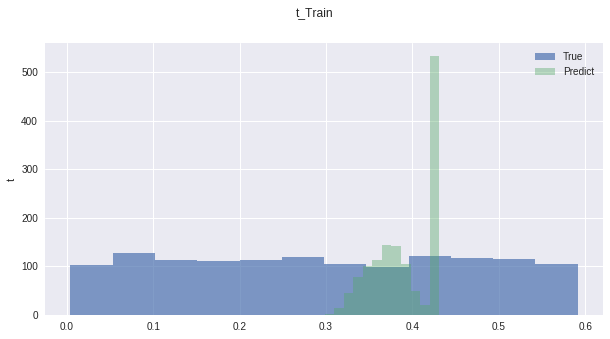

pred (1344, 1)
true (1344,)
<---------- Train ---------->
AVERAGE GAP 0    0.208177
dtype: float64
<---------- TRUE ---------->
count    1344.000000
mean        0.508715
std         0.221070
min         0.000000
25%         0.322786
50%         0.598182
75%         0.691701
max         1.000000
Name: ∆w_s, dtype: float64
<---------- PREDICT ---------->
count    1344.000000
mean        0.404053
std         0.026255
min         0.336917
25%         0.383075
50%         0.402109
75%         0.432267
max         0.432313
Name: 0, dtype: float64


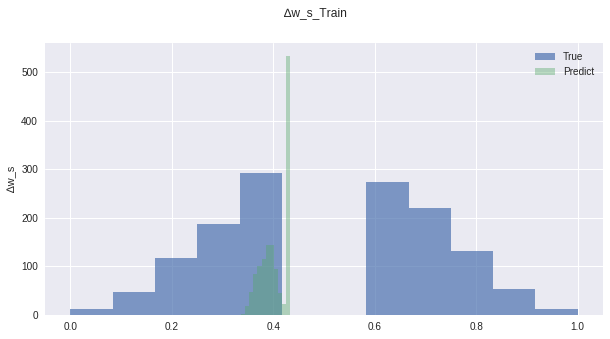

pred (1344, 1)
true (1344,)
<---------- Train ---------->
AVERAGE GAP 0    0.283307
dtype: float64
<---------- TRUE ---------->
count    1344.000000
mean        0.084207
std         0.086777
min         0.000000
25%         0.037037
50%         0.057870
75%         0.094907
max         1.000000
Name: ∆t, dtype: float64
<---------- PREDICT ---------->
count    1344.000000
mean        0.361505
std         0.037373
min         0.266580
25%         0.331360
50%         0.359004
75%         0.401776
max         0.401844
Name: 0, dtype: float64


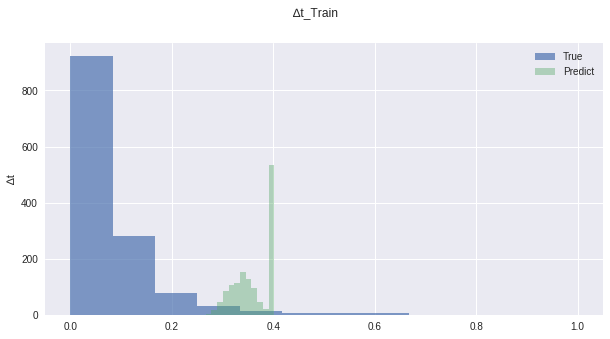

pred (1344, 1)
true (1344,)
<---------- Train ---------->
AVERAGE GAP 0    0.195697
dtype: float64
<---------- TRUE ---------->
count    1344.000000
mean        0.514396
std         0.207007
min         0.000000
25%         0.339446
50%         0.547654
75%         0.690676
max         1.000000
Name: θ(∆w_s), dtype: float64
<---------- PREDICT ---------->
count    1344.000000
mean        0.405502
std         0.025970
min         0.338957
25%         0.384780
50%         0.403626
75%         0.433406
max         0.433451
Name: 0, dtype: float64


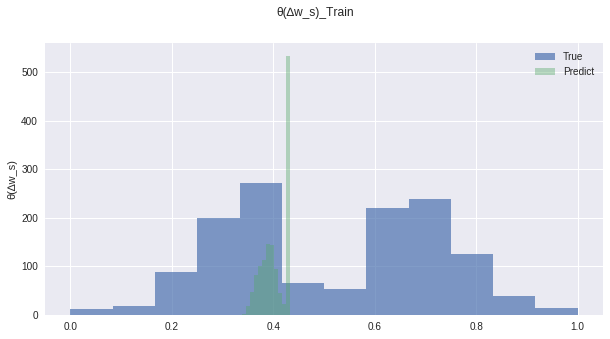

In [0]:
# Short and Long Term Prediction in 2016
# Plot.plot_comparison(model_v4, start_idx=2, length=114, train=False)
Plot.plot_comparison(model_v4, start_idx=2, length=1344, train=True)

In [0]:
# Short and Long Term Prediction in 2016
plot_prediction(true, model_v4, start_month=1, end_month=1)
plot_prediction(true, model_v4, start_month=1, end_month=3)
plot_prediction(true, model_v4, start_month=1, end_month=6)
plot_prediction(true, model_v4, start_month=1, end_month=12)

(744, 2)
true_expand (1, 744, 2)


ValueError: ignored

x shape (1, 2000, 8)
y_pred shape (1, 2000, 4)
y_true (2000, 4)
y_pred (1, 2000, 4)
pred (2000, 1)
true (2000,)
AVERAGE GAP 0    0.004759
dtype: float64
<---------- TRUE ---------->


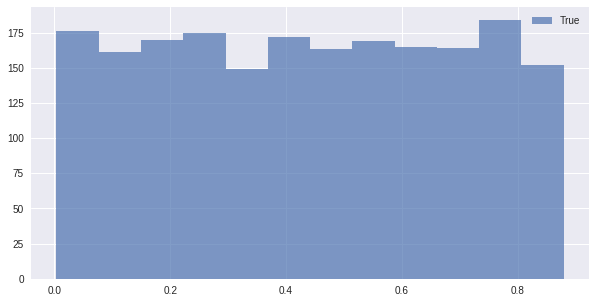

count    2000.000000
mean        0.439865
std         0.252745
min         0.003640
25%         0.218665
50%         0.438910
75%         0.660659
max         0.879419
Name: t, dtype: float64
<---------- TRUE ---------->
<---------- PREDICT ---------->


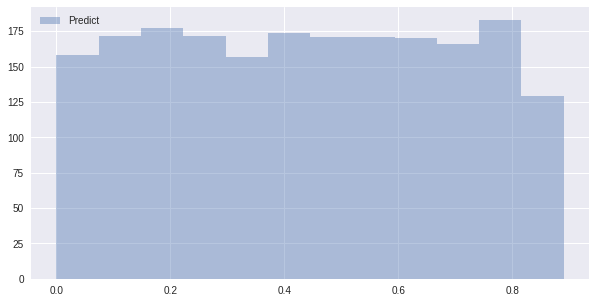

count    2000.000000
mean        0.440294
std         0.251498
min         0.000000
25%         0.220156
50%         0.441197
75%         0.660371
max         0.890450
Name: 0, dtype: float64
<---------- PREDICT ---------->
pred (2000, 1)
true (2000,)
AVERAGE GAP 0    0.017166
dtype: float64
<---------- TRUE ---------->


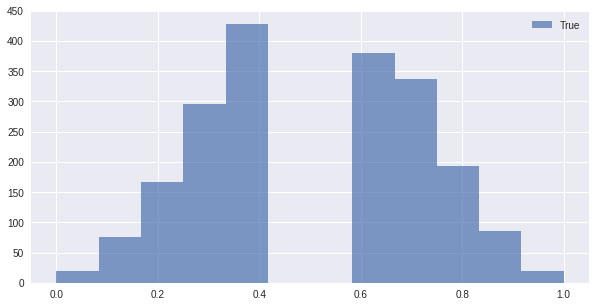

count    2000.000000
mean        0.507673
std         0.223518
min         0.000000
25%         0.319424
50%         0.596158
75%         0.694512
max         1.000000
Name: ∆w_s, dtype: float64
<---------- TRUE ---------->
<---------- PREDICT ---------->


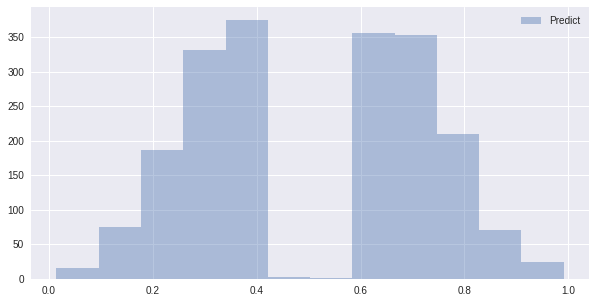

count    2000.000000
mean        0.508378
std         0.221141
min         0.014095
25%         0.316842
50%         0.597596
75%         0.699539
max         0.991215
Name: 0, dtype: float64
<---------- PREDICT ---------->
pred (2000, 1)
true (2000,)
AVERAGE GAP 0    0.004286
dtype: float64
<---------- TRUE ---------->


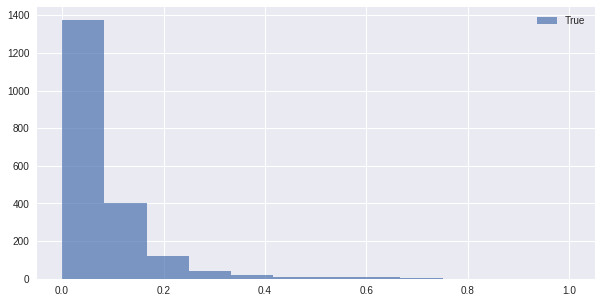

count    2000.000000
mean        0.085851
std         0.091157
min         0.000000
25%         0.037037
50%         0.057870
75%         0.097222
max         1.000000
Name: ∆t, dtype: float64
<---------- TRUE ---------->
<---------- PREDICT ---------->


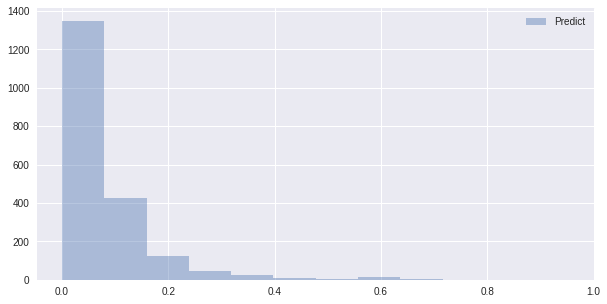

count    2000.000000
mean        0.084650
std         0.088710
min         0.000000
25%         0.036882
50%         0.057878
75%         0.094266
max         0.954391
Name: 0, dtype: float64
<---------- PREDICT ---------->
pred (2000, 1)
true (2000,)
AVERAGE GAP 0    0.035741
dtype: float64
<---------- TRUE ---------->


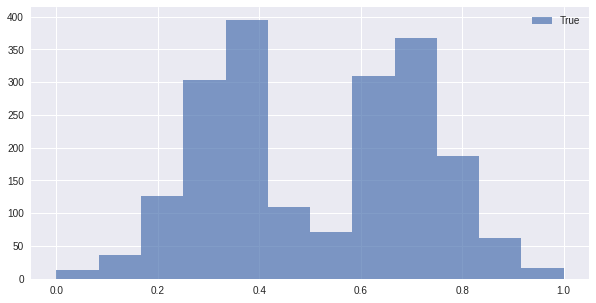

count    2000.000000
mean        0.514209
std         0.207245
min         0.000000
25%         0.338397
50%         0.529834
75%         0.693288
max         1.000000
Name: θ(∆w_s), dtype: float64
<---------- TRUE ---------->
<---------- PREDICT ---------->


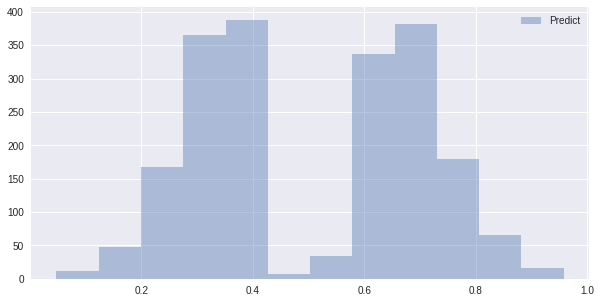

count    2000.000000
mean        0.507951
std         0.197671
min         0.047220
25%         0.335896
50%         0.568306
75%         0.680094
max         0.958364
Name: 0, dtype: float64
<---------- PREDICT ---------->
x shape (1, 113, 8)
y_pred shape (1, 113, 4)
y_true (113, 4)
y_pred (1, 113, 4)
pred (113, 1)
true (113,)
AVERAGE GAP 0    0.013281
dtype: float64
<---------- TRUE ---------->


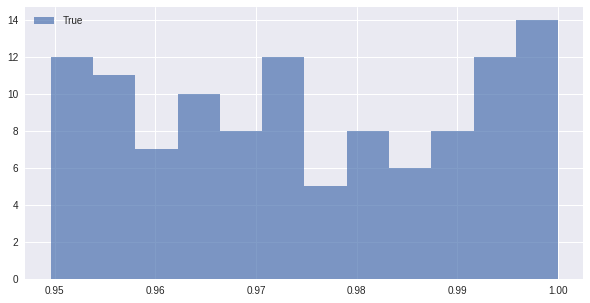

count    113.000000
mean       0.974967
std        0.015763
min        0.949617
25%        0.961664
50%        0.973445
75%        0.990534
max        1.000000
Name: t, dtype: float64
<---------- TRUE ---------->
<---------- PREDICT ---------->


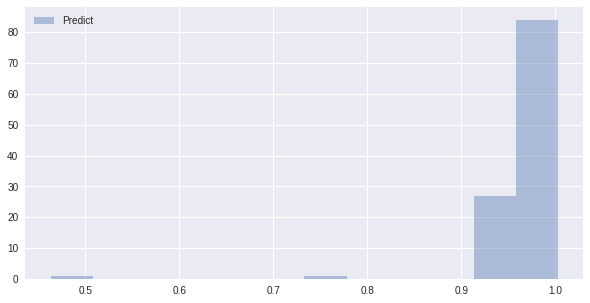

count    113.000000
mean       0.964202
std        0.053838
min        0.463113
25%        0.957505
50%        0.971653
75%        0.983013
max        1.002852
Name: 0, dtype: float64
<---------- PREDICT ---------->
pred (113, 1)
true (113,)
AVERAGE GAP 0    0.017291
dtype: float64
<---------- TRUE ---------->


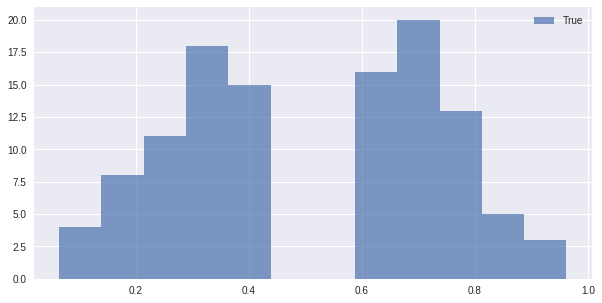

count    113.000000
mean       0.507154
std        0.232631
min        0.064216
25%        0.305229
50%        0.605277
75%        0.704343
max        0.962147
Name: ∆w_s, dtype: float64
<---------- TRUE ---------->
<---------- PREDICT ---------->


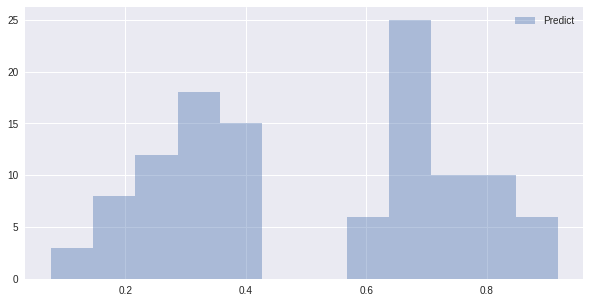

count    113.000000
mean       0.510378
std        0.234874
min        0.076638
25%        0.301436
50%        0.600717
75%        0.699199
max        0.918216
Name: 0, dtype: float64
<---------- PREDICT ---------->
pred (113, 1)
true (113,)
AVERAGE GAP 0    0.004801
dtype: float64
<---------- TRUE ---------->


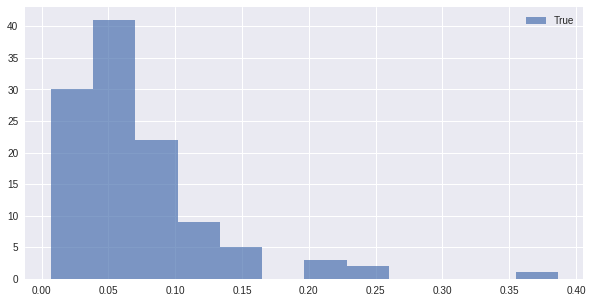

count    113.000000
mean       0.071800
std        0.055665
min        0.006944
25%        0.037037
50%        0.055556
75%        0.087963
max        0.386574
Name: ∆t, dtype: float64
<---------- TRUE ---------->
<---------- PREDICT ---------->


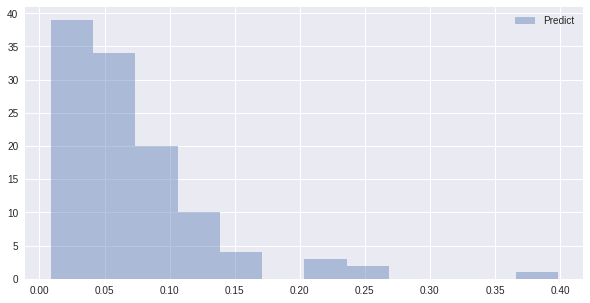

count    113.000000
mean       0.070617
std        0.057974
min        0.008722
25%        0.032336
50%        0.054023
75%        0.091593
max        0.398483
Name: 0, dtype: float64
<---------- PREDICT ---------->
pred (113, 1)
true (113,)
AVERAGE GAP 0    0.035088
dtype: float64
<---------- TRUE ---------->


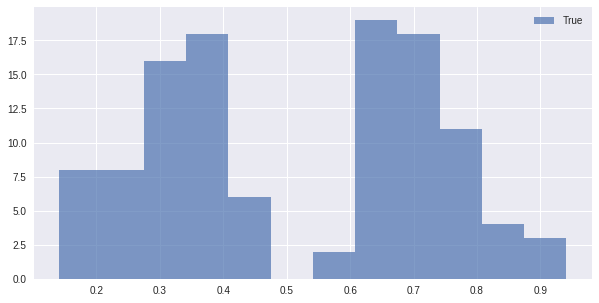

count    113.000000
mean       0.516506
std        0.215648
min        0.141411
25%        0.327371
50%        0.574403
75%        0.709725
max        0.940965
Name: θ(∆w_s), dtype: float64
<---------- TRUE ---------->
<---------- PREDICT ---------->


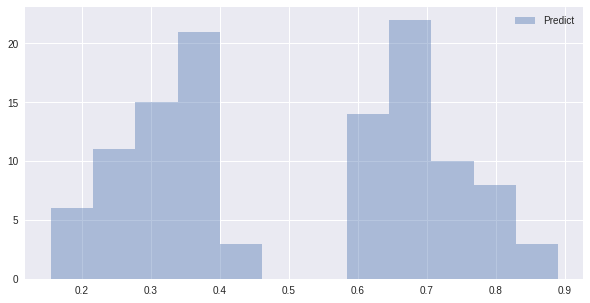

count    113.000000
mean       0.507318
std        0.208370
min        0.154578
25%        0.322713
50%        0.589892
75%        0.695940
max        0.890472
Name: 0, dtype: float64
<---------- PREDICT ---------->


In [0]:
Plot.plot_comparison(model_v1, start_idx=1, length=2000, train=True)
Plot.plot_comparison(model_v1, start_idx=1, length=120, train=False)

### Plot Prediction

In [0]:

#Short Term Prediction(1month・3months)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    mse = (abs(y_true - y_pred)**2).mean(axis=0)
    return mse
  
def data_extract(fileName):
    df = Data.dataLocalExtract()
    return df

def plot_prediction(data, model, start_month, end_month):

        # Select the sequences from the given start-index and
        # of the given length.

        true = data.loc[start_month:end_month, :]
        print(true.shape)
        # Input-signals for the model.
        true_expand = np.expand_dims(true, axis=0) #axis=0
        print("true_expand", true_expand.shape)
        # Use the model to predict the output-signals.
        pred = model.predict(true_expand)
        print("pred shape", pred.shape)
        for signal in range(len(target)):
          # Get the output-signal predicted by the model.
          signal_pred = pred[0, :, signal] #   pred[0, :, 0]
          signal_pred = pd.DataFrame(signal_pred)

          print('<'+'-'*10 + str(start_month) + '-' + str(end_month) +'-'*10 + '>')
          print("pred", signal_pred.shape)
          signal_true = true[str(target[signal])]
          print('<'+'-'*10 + str(target[signal]) +'-'*10 + '>')
          print("true", signal_true.shape)
          signal_pred.index = signal_true.index
          gap = pd.DataFrame(abs(signal_pred[0]- signal_true))
          print("MAPE: ", mean_absolute_percentage_error(signal_true, signal_pred[0]))
          print("MSE: ", mse(signal_true, signal_pred[0]))
          
          gap.columns = ['gap']

          dfResult = pd.concat([signal_pred,  signal_true, gap], axis=1, join_axes=[signal_pred.index])

          dfResult.columns = ['Predict', 'True', 'Gap(Predict - True)']
          print("AVERAGE GAP", gap.mean())
          print('<'+'-'*10+ '-'*10 + '>')
          print(dfResult.describe())
          print('<'+'-'*10+ '-'*10 + '>')
          fig, ax1 = plt.subplots(figsize=(10,5))
          ax2 = ax1.twinx()
          plt.hist(signal_true, alpha=0.7)
          plt.hist(signal_pred[0], alpha=0.4)
          plt.show()
          ax3 = ax1.twinx()


fileName = 'significant_events_output_2016.xlsx'
df_pred = data_extract(fileName)

df_pred['w_s(t)'] = min_max_normalization(df_pred['w_s(t)'])
df_pred['w_s(t+∆t)'] = min_max_normalization(df_pred['w_s(t+∆t)'])
df_pred['t'] = min_max_normalization(df_pred['t'])
df_pred['t+∆t'] = min_max_normalization(df_pred['t+∆t'])
df_pred['∆w_s'] = min_max_normalization(df_pred['∆w_s'])
df_pred['∆t'] = min_max_normalization(df_pred['∆t'])
df_pred['θ(∆w_s)'] = min_max_normalization(df_pred['θ(∆w_s)'])

true = df_pred.loc[:, ['w_s(t)', 'w_s(t+∆t)','t','t+∆t','∆w_s','∆t','θ(∆w_s)','mean(∆w_s)']].fillna(0)
true = true.set_index([true.index.month, true.index])
true.index.names = ['month', 'time']

# print("True Description", true.describe())#true.to_csv('./true.csv')
print(true.describe())



           w_s(t)   w_s(t+∆t)           t        t+∆t        ∆w_s          ∆t  \
count  142.000000  142.000000  142.000000  142.000000  142.000000  142.000000   
mean     0.368981    0.365861    0.546815    0.538150    0.509414    0.120802   
std      0.246835    0.288298    0.309939    0.316874    0.235640    0.141396   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.149981    0.097054    0.271225    0.255818    0.305936    0.041209   
50%      0.343586    0.290632    0.566281    0.566819    0.597380    0.069597   
75%      0.566056    0.614907    0.846786    0.846292    0.709146    0.145604   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

          θ(∆w_s)  mean(∆w_s)  
count  142.000000  142.000000  
mean     0.507328    0.303779  
std      0.242688    0.126278  
min      0.000000    0.112724  
25%      0.306204    0.208424  
50%      0.554260    0.283190  
75%      0.711858    0.384342  
max      1.000

(8, 8)
true_expand (1, 8, 8)
pred shape (1, 8, 4)
<----------1-1---------->
pred (8, 1)
<----------t---------->
true (8,)
MAPE:  inf
MSE:  0.003389343636122229
AVERAGE GAP gap    0.045496
dtype: float64
<-------------------->
        Predict      True  Gap(Predict - True)
count  8.000000  8.000000             8.000000
mean   0.068092  0.043223             0.045496
std    0.032270  0.025050             0.038833
min    0.035443  0.000000             0.011506
25%    0.045698  0.026782             0.019730
50%    0.050993  0.047376             0.025113
75%    0.094432  0.063388             0.067650
max    0.118667  0.071150             0.118667
<-------------------->


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


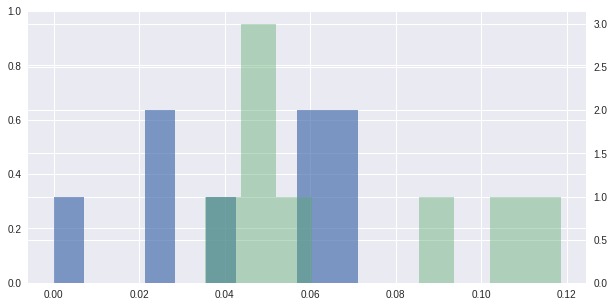

<----------1-1---------->
pred (8, 1)
<----------∆w_s---------->
true (8,)
MAPE:  10.131728829577444
MSE:  0.005514243323680364
AVERAGE GAP gap    0.055168
dtype: float64
<-------------------->
        Predict      True  Gap(Predict - True)
count  8.000000  8.000000             8.000000
mean   0.555596  0.604711             0.055168
std    0.254767  0.256164             0.053138
min    0.210593  0.247843             0.020897
25%    0.308626  0.362690             0.026819
50%    0.626730  0.678255             0.035140
75%    0.699571  0.761680             0.056825
max    0.949951  0.970849             0.181784
<-------------------->


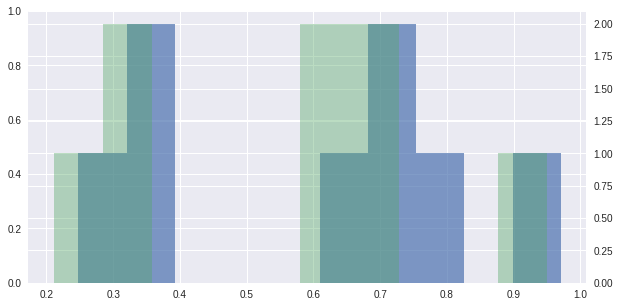

<----------1-1---------->
pred (8, 1)
<----------∆t---------->
true (8,)
MAPE:  15.52139170809847
MSE:  0.0008828274458182208
AVERAGE GAP gap    0.023356
dtype: float64
<-------------------->
        Predict      True  Gap(Predict - True)
count  8.000000  8.000000             8.000000
mean   0.218068  0.229396             0.023356
std    0.244593  0.268818             0.019634
min    0.041128  0.047619             0.006491
25%    0.084158  0.075092             0.011173
50%    0.103033  0.093407             0.015549
75%    0.255093  0.274725             0.028504
max    0.765918  0.831502             0.065584
<-------------------->


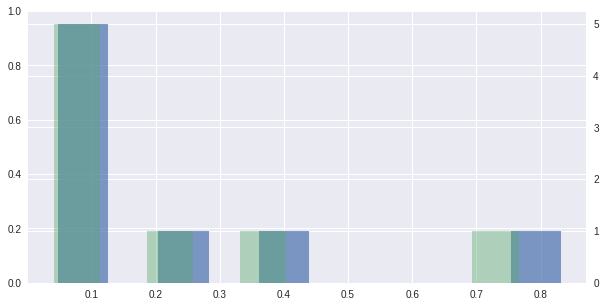

<----------1-1---------->
pred (8, 1)
<----------θ(∆w_s)---------->
true (8,)
MAPE:  9.569779785245741
MSE:  0.003914093176978811
AVERAGE GAP gap    0.047434
dtype: float64
<-------------------->
        Predict      True  Gap(Predict - True)
count  8.000000  8.000000             8.000000
mean   0.563462  0.555698             0.047434
std    0.202411  0.192781             0.043610
min    0.329254  0.266679             0.008387
25%    0.354982  0.394662             0.010417
50%    0.603887  0.592065             0.037891
75%    0.703077  0.730600             0.072841
max    0.859545  0.769181             0.126182
<-------------------->


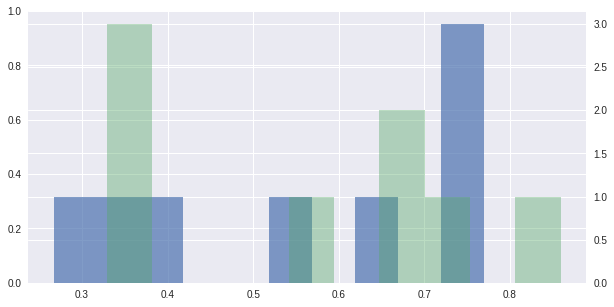

(33, 8)
true_expand (1, 33, 8)
pred shape (1, 33, 4)
<----------1-3---------->
pred (33, 1)
<----------t---------->
true (33,)
MAPE:  inf
MSE:  0.000963534456534416
AVERAGE GAP gap    0.020147
dtype: float64
<-------------------->
         Predict       True  Gap(Predict - True)
count  33.000000  33.000000            33.000000
mean    0.122202   0.125031             0.020147
std     0.055766   0.064180             0.023981
min     0.035443   0.000000             0.000147
25%     0.080730   0.079285             0.008995
50%     0.115545   0.122823             0.015489
75%     0.161642   0.177131             0.019735
max     0.234087   0.241522             0.118667
<-------------------->


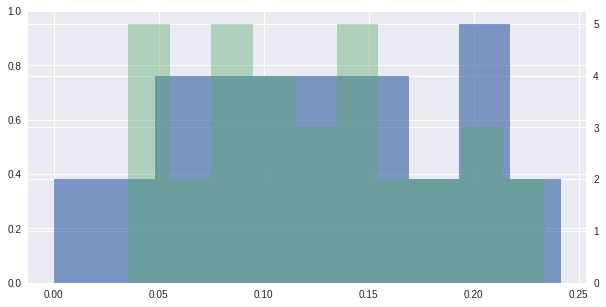

<----------1-3---------->
pred (33, 1)
<----------∆w_s---------->
true (33,)
MAPE:  7.070562887870737
MSE:  0.0018589777891281057
AVERAGE GAP gap    0.030544
dtype: float64
<-------------------->
         Predict       True  Gap(Predict - True)
count  33.000000  33.000000            33.000000
mean    0.502932   0.514244             0.030544
std     0.240008   0.236941             0.030902
min     0.090453   0.096442             0.000378
25%     0.305902   0.332111             0.017651
50%     0.598720   0.607854             0.024212
75%     0.642573   0.656872             0.032533
max     0.949951   0.970849             0.181784
<-------------------->


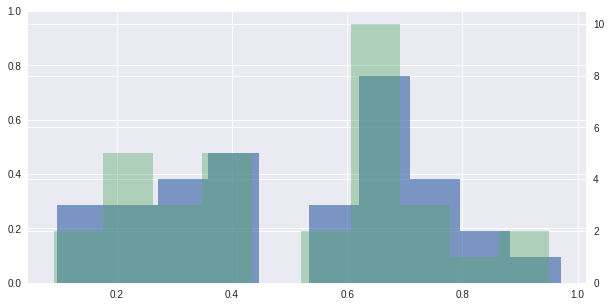

<----------1-3---------->
pred (33, 1)
<----------∆t---------->
true (33,)
MAPE:  15.543321273942572
MSE:  0.0003550031152837631
AVERAGE GAP gap    0.013873
dtype: float64
<-------------------->
         Predict       True  Gap(Predict - True)
count  33.000000  33.000000            33.000000
mean    0.158987   0.165057             0.013873
std     0.165259   0.180135             0.012947
min     0.020753   0.014652             0.000834
25%     0.054141   0.054945             0.005859
50%     0.092248   0.076923             0.010147
75%     0.220536   0.234432             0.019841
max     0.765918   0.831502             0.065584
<-------------------->


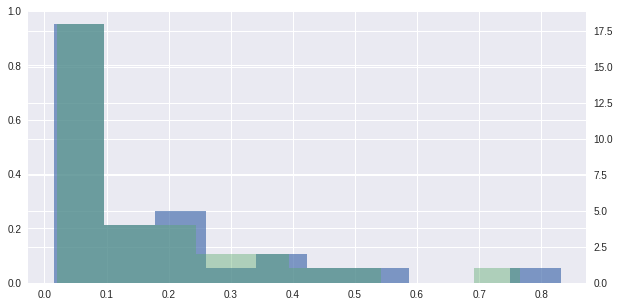

<----------1-3---------->
pred (33, 1)
<----------θ(∆w_s)---------->
true (33,)
MAPE:  10.419992617252237
MSE:  0.0025593736126405904
AVERAGE GAP gap    0.041782
dtype: float64
<-------------------->
         Predict       True  Gap(Predict - True)
count  33.000000  33.000000            33.000000
mean    0.505288   0.505787             0.041782
std     0.209336   0.219465             0.028966
min     0.149978   0.134980             0.004379
25%     0.331240   0.317398             0.016973
50%     0.556203   0.545766             0.037852
75%     0.647442   0.667559             0.062040
max     0.960361   1.000000             0.126182
<-------------------->


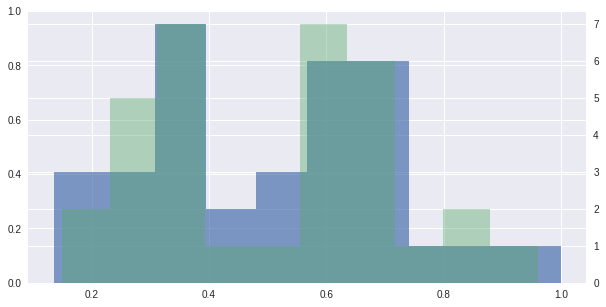

(60, 8)
true_expand (1, 60, 8)
pred shape (1, 60, 4)
<----------1-6---------->
pred (60, 1)
<----------t---------->
true (60,)
MAPE:  inf
MSE:  0.0006201803898603308
AVERAGE GAP gap    0.016704
dtype: float64
<-------------------->
         Predict       True  Gap(Predict - True)
count  60.000000  60.000000            60.000000
mean    0.224114   0.230643             0.016704
std     0.129817   0.134972             0.018626
min     0.035443   0.000000             0.000147
25%     0.111635   0.117238             0.009318
50%     0.206481   0.208925             0.013850
75%     0.316360   0.332006             0.018515
max     0.459587   0.465170             0.118667
<-------------------->


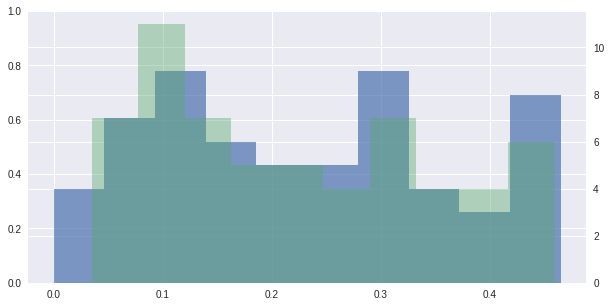

<----------1-6---------->
pred (60, 1)
<----------∆w_s---------->
true (60,)
MAPE:  5.802453161444198
MSE:  0.0012116521873745943
AVERAGE GAP gap    0.02471
dtype: float64
<-------------------->
         Predict       True  Gap(Predict - True)
count  60.000000  60.000000            60.000000
mean    0.503593   0.509000             0.024710
std     0.235655   0.230644             0.024723
min     0.090453   0.092419             0.000108
25%     0.299117   0.327761             0.013617
50%     0.597553   0.600372             0.021322
75%     0.676585   0.701014             0.030127
max     0.949951   0.970849             0.181784
<-------------------->


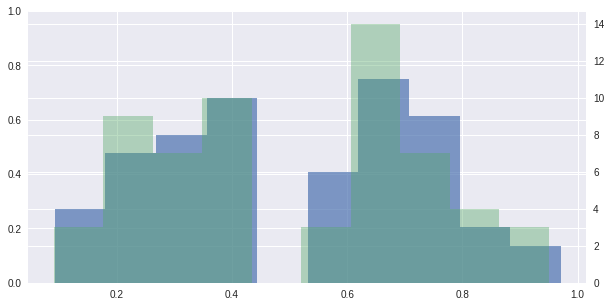

<----------1-6---------->
pred (60, 1)
<----------∆t---------->
true (60,)
MAPE:  12.833747301216505
MSE:  0.00026590147189428377
AVERAGE GAP gap    0.011787
dtype: float64
<-------------------->
         Predict       True  Gap(Predict - True)
count  60.000000  60.000000            60.000000
mean    0.151273   0.156166             0.011787
std     0.176818   0.187279             0.011363
min     0.016180   0.014652             0.000113
25%     0.052637   0.054029             0.004232
50%     0.081550   0.076923             0.006758
75%     0.181498   0.191392             0.017084
max     0.979342   1.000000             0.065584
<-------------------->


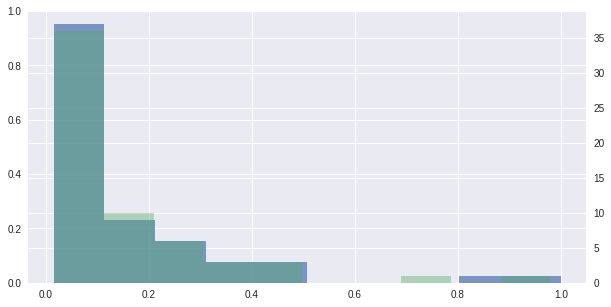

<----------1-6---------->
pred (60, 1)
<----------θ(∆w_s)---------->
true (60,)
MAPE:  10.413703561110104
MSE:  0.0025347931824938686
AVERAGE GAP gap    0.042077
dtype: float64
<-------------------->
         Predict       True  Gap(Predict - True)
count  60.000000  60.000000            60.000000
mean    0.499309   0.501504             0.042077
std     0.206147   0.215654             0.027879
min     0.149978   0.134980             0.004379
25%     0.314602   0.316958             0.020469
50%     0.552116   0.536581             0.037908
75%     0.663930   0.669533             0.059158
max     0.960361   1.000000             0.126182
<-------------------->


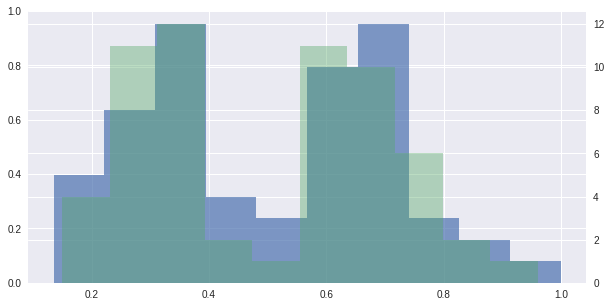

(142, 8)
true_expand (1, 142, 8)
pred shape (1, 142, 4)
<----------1-12---------->
pred (142, 1)
<----------t---------->
true (142,)
MAPE:  inf
MSE:  0.00034583855961640026
AVERAGE GAP gap    0.012828
dtype: float64
<-------------------->
          Predict        True  Gap(Predict - True)
count  142.000000  142.000000           142.000000
mean     0.538839    0.546815             0.012828
std      0.307944    0.309939             0.013512
min      0.035443    0.000000             0.000147
25%      0.257215    0.271225             0.005647
50%      0.555560    0.566281             0.010970
75%      0.842980    0.846786             0.016500
max      0.995412    1.000000             0.118667
<-------------------->


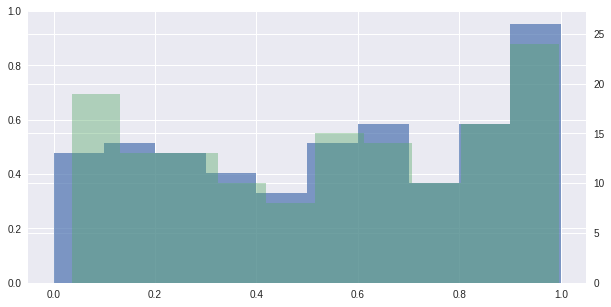

<----------1-12---------->
pred (142, 1)
<----------∆w_s---------->
true (142,)
MAPE:  nan
MSE:  0.0011303885553997726
AVERAGE GAP gap    0.025604
dtype: float64
<-------------------->
          Predict        True  Gap(Predict - True)
count  142.000000  142.000000           142.000000
mean     0.508553    0.509414             0.025604
std      0.249836    0.235640             0.021867
min      0.000000    0.000000             0.000000
25%      0.289826    0.305936             0.011700
50%      0.600221    0.597380             0.021420
75%      0.720071    0.709146             0.033690
max      1.008421    1.000000             0.181784
<-------------------->


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


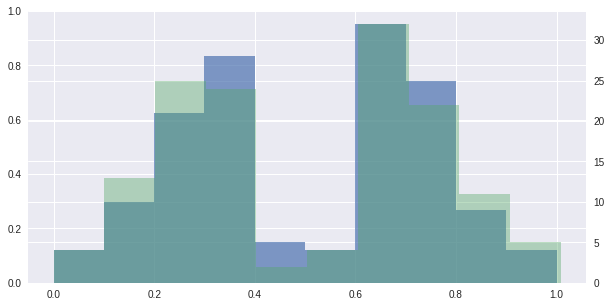

<----------1-12---------->
pred (142, 1)
<----------∆t---------->
true (142,)
MAPE:  nan
MSE:  0.00013526347803363343
AVERAGE GAP gap    0.007727
dtype: float64
<-------------------->
          Predict        True  Gap(Predict - True)
count  142.000000  142.000000           142.000000
mean     0.116988    0.120802             0.007727
std      0.135582    0.141396             0.008723
min      0.000000    0.000000             0.000000
25%      0.040542    0.041209             0.002462
50%      0.065098    0.069597             0.005303
75%      0.144647    0.145604             0.009587
max      0.979342    1.000000             0.065584
<-------------------->


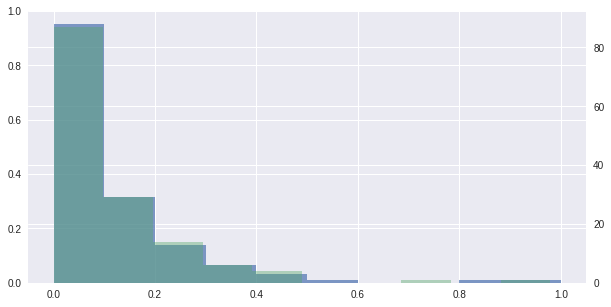

<----------1-12---------->
pred (142, 1)
<----------θ(∆w_s)---------->
true (142,)
MAPE:  inf
MSE:  0.002936673604202078
AVERAGE GAP gap    0.045708
dtype: float64
<-------------------->
          Predict        True  Gap(Predict - True)
count  142.000000  142.000000           142.000000
mean     0.503808    0.507328             0.045708
std      0.224332    0.242688             0.029214
min      0.079796    0.000000             0.000724
25%      0.303353    0.306204             0.023267
50%      0.571667    0.554260             0.040725
75%      0.694673    0.711858             0.063078
max      0.960361    1.000000             0.126182
<-------------------->


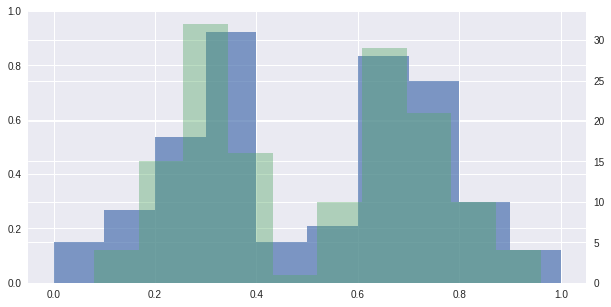

In [0]:
plot_prediction(true, model_v1, start_month=1, end_month=1)
plot_prediction(true, model_v1, start_month=1, end_month=3)
plot_prediction(true, model_v1, start_month=1, end_month=6)
plot_prediction(true, model_v1, start_month=1, end_month=12)